In [571]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

%matplotlib inline

In [572]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

# сразу создам
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

# создаем отдельный дата фрейм без столбцов с некоректными данными, чтобы предсказывать на них строки в которых пропуски
columns_all_val = ['DistrictId', 'Rooms', 'Square', 'Floor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2']
X_norm = X[columns_all_val].copy()
X_final_norm = X_final[columns_all_val].copy()

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


374

In [573]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()        
    
    @staticmethod
    def year_norm(x):
        x = str(x)
        if len(x) > 4 and x[0] in ['1', '2']:
            return int(x[:4])
        elif len(x) == 4 and (not x[0] in ['1', '2']):
            if int(x[1]) == 0:
                x[0] = '2'
                return int(x)
            else:
                x[0] = '1'
                return int(x)
        else:
            return datetime.datetime.now().year
    
   
    def transform(self, X):
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = X.loc[X['HouseYear'] > 2020, 'HouseYear'].agg(self.year_norm)
                
        # Square < 10 | Square > 300
        X.loc[X['Square'] < 10, 'Square'] *= 10
        X.loc[X['Square'] > 300, 'Square'] /= 10

        # Rooms = 0
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] < 50), 'Rooms'] = 1
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] >= 50) & (X['Square'] < 90), 'Rooms'] = 2
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] >= 90), 'Rooms'] = 3
                      
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)


        # HouseFloor, Floor
        if 'HouseFloor' in X.columns:
            X['HouseFloor_outlier'] = 0
            X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

            X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']

            X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']  
        
        
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            

        X['DistrictId'] = X['DistrictId'].astype('category')
        
        return X
        

In [574]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X) 
X_norm = imputer.transform(X_norm)
X_final_norm = imputer.transform(X_final_norm)
X_final = imputer.transform(X_final)

In [575]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.mapping_year_kethen = None
        self.district_counts = None
        self.df = None
        self.med_param_s = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        self.DistrictId_counts = dict(district)
      
        self.district_counts = dict(np.log(X['DistrictId'].value_counts()*100/X['DistrictId'].value_counts().max()+1)*100//10)
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        X = self.year_to_cat(X)
        
        df = X.copy()
        
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            X['Group_Square'] = X['Square'].round()//10*10
            self.df = X.loc[~X['LifeSquare'].isna() & (X['KitchenSquare'] > 1) & (X['Group_Square'] >= 30) & (X['Group_Square']<=90)].copy()
            self.med_param_s = self.df.groupby(['Group_Square', 'year_cat'], as_index=False).agg({'KitchenSquare':'median', 'S_LfS':'median'}).\
                                                        rename(columns={'KitchenSquare':'MedKitchenSquare',
                                                                       'S_LfS': 'MedS_LfS'})
            
        
        if y is not None:
            df['Price'] = y.values
            df['Price'] /= df['Square']
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        df = self.year_to_cat(df)
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df['Price'] /= df['Square']
            df = self.floor_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            self.mapping_rooms_kethen = df.groupby('Rooms')['KitchenSquare'].median().round(0).to_dict()

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['Group_Square'] = X['Square'].round()//10*10
        
        # Binary features
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X.drop(['Ecology_2', 'Ecology_3'], axis=1, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец flooar_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        X['Group_Square'] = X['Square'].round()//10*10
        X.loc[X['Group_Square'] > 90, 'Group_Square'] = 90
        X.loc[X['Group_Square'] < 30, 'Group_Square'] = 30
        X = X.merge(self.med_param_s, on=['Group_Square', 'year_cat'], how='left')
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            X['MedS_LfS'] = X['S_LfS'] - X['MedS_LfS']
            
        # KitchenSquare, LifeSquare 
        # Замена подозрительных данных  в площади кухни и жилой площади. В части строх жилая и общая площадь поменяны местами
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X.loc[X['KitchenSquare'] > X['Square']/2, 'KitchenSquare'] = 1 
            X['S_new'] = 0
            
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']

            X.loc[X['KitchenSquare'] < 2, 'S_new'] = 1
            X.loc[X['KitchenSquare'] < 2, 'KitchenSquare'] = X.loc[(X['KitchenSquare'] < 2), 'MedKitchenSquare']
            X.loc[X['LifeSquare'].isna(), 'S_new'] = 1
            X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X.loc[X['LifeSquare'].isna(), 'Square']- \
                                X.loc[X['LifeSquare'].isna(), 'KitchenSquare'] -  X.loc[X['LifeSquare'].isna(), 'MedS_LfS']
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            
            X.loc[(X['LifeSquare']-X['Square']).abs() > 150, 'S_new'] = 1

            X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = X.loc[X['LifeSquare'] < 10, 'Square'] - X.loc[X['LifeSquare'] < 10, 'LifeSquare']

            X['Square_new'] = X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']) & (X['Square'] < X['LifeSquare']), 'Square']
            X['LifeSquare_new'] = X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']) & (X['Square'] < X['LifeSquare']), 'LifeSquare']
            X.loc[~X['Square_new'].isna(), 'Square'] = X.loc[~X['Square_new'].isna(), 'LifeSquare_new']
            X.loc[~X['LifeSquare_new'].isna(), 'LifeSquare'] = X.loc[~X['LifeSquare_new'].isna(), 'Square_new']

            X.loc[~X['LifeSquare_new'].isna(), 'S_new'] = 1
            X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']), 'S_new'] = 1
            X.drop(['Square_new', 'LifeSquare_new'], axis=1, inplace=True)

            X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']), 'LifeSquare'] =  X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']), 'LifeSquare'] - X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']), 'KitchenSquare']
         
        # полиномиальные фичи (оставлены только значимые комбинации, не все, думаю можно ещё улучшить перебирая комбинации)
        # from sklearn.preprocessing import PolynomialFeatures помог + анализ значимых фич в разных моделях

        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['MedKitchenSquare_D'] = X['Rooms'].map(self.mapping_rooms_kethen)
            X['Square *MedKitchenSquare_D']=  X['Square'] *  X['MedKitchenSquare_D']
            X['MedKitchenSquare *MedPriceByDistrict']=  X['MedKitchenSquare'] *  X['MedPriceByDistrict']
            X['HouseFloor *Social_3']=  X['HouseFloor'] *  X['Social_3']
    
        X['Square* MedPriceByFloorYear']=  X['Square'] *  X['MedPriceByFloorYear']
        X['Square *MedPriceByDistrict']=  X['Square'] *  X['MedPriceByDistrict']
        X['DistrictId_count* MedPriceByFloorYear']=  X['DistrictId_count'] *  X['MedPriceByFloorYear']
        X['HouseYear *DistrictId_count']=  X['HouseYear'] *  X['DistrictId_count']
        X['Square *new_district']=  X['Square'] *  X['new_district']
        X['Social_3 *new_district']=  X['Social_3'] *  X['new_district']
        X['Rooms *Social_1']=  X['Rooms'] *  X['Social_1']
        X['Rooms *MedPriceByFloorYear']=  X['Rooms'] *  X['MedPriceByFloorYear']
        
        X['Rooms *MedPriceByDistrict']=  X['Rooms'] *  X['MedPriceByDistrict']    
            
        X['Soc_1*Soc_2'] =  X['Social_2'] *  X['Social_1']
        X['Soc_2*Soc_3'] =  X['Social_2'] *  X['Social_3']
        X['Soc_3*Eco_1'] =  X['Social_3'] *  X['Ecology_1'] 
        
        X['DistrictId_count'] = X['DistrictId'].map(self.district_counts)
        X['DistrictId'] = X['DistrictId'].astype('category')
        
        X.fillna(0, inplace=True)
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 7
        X.loc[(X['HouseYear'] == 1977), 'year_cat'] = 4
        X['year_cat'] = X['year_cat'].astype('category')
        
            
        return X
    

In [576]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_norm = features.transform(X_norm)
X_final = features.transform(X_final)
X_final_norm = features.transform(X_final_norm)

In [580]:
model_min = LGBMRegressor(max_depth=4, min_samples_leaf=10, n_estimators=300, random_state=42)

model_f_min = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, max_features=10)

model_v_min = VotingRegressor([('model_1', model_f_min), ('model_2', model_min)])

cv_score = cross_val_score(model_v_min, X_norm, y['Price'].ravel(), 
                           scoring='r2', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))

# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
# R2: 0.756 +- 0.026
model_v_min.fit(X_norm, y['Price'].ravel())

R2: 0.756 +- 0.026


VotingRegressor(estimators=[('model_1',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=15,
                                                   max_features=10,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=200,
                                      

In [581]:
model1 = GradientBoostingRegressor(n_estimators=200, max_depth=5, min_samples_split=20,
                                           learning_rate=0.1, loss='huber', random_state=42)

model_full = LGBMRegressor(max_depth=7, min_samples_leaf=10, n_estimators=150, random_state=42)

model_v = VotingRegressor([('model_1', model1), ('model_2', model_full)])

cv_score = cross_val_score(model_v, X, y['Price'].ravel(), 
                           scoring='r2', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))

# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))
# R2: 0.762 +- 0.025 
model_v.fit(X, y['Price'].ravel())

R2: 0.762 +- 0.025


VotingRegressor(estimators=[('model_1',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='huber',
                                                       max_depth=5,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=20,
                                                       mi

In [585]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" 
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values['Price'])
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.915



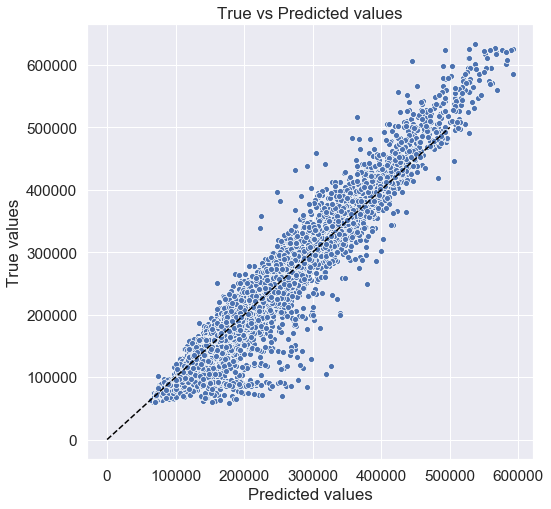

In [586]:
y_train_preds_min = model_v_min.predict(X_norm)
evaluate_preds(y, y_train_preds_min)

R2:	0.89



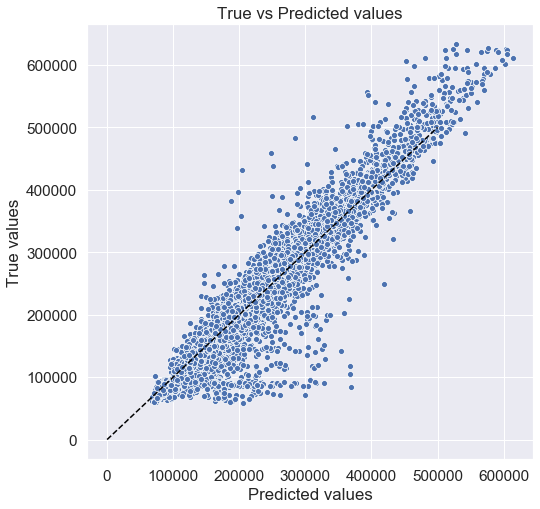

In [587]:
y_train_preds = model_v.predict(X)
evaluate_preds(y, y_train_preds)

In [588]:
y_pred_final_min = model_v_min.predict(X_final_norm)

In [589]:
y_pred_final = model_v.predict(X_final)

In [590]:
preds_final_full['Price_1'] =  y_pred_final_min
preds_final_full['Price_2'] =  y_pred_final
preds_final_full['null'] = 0
preds_final_full.loc[X_final['S_new'] == 1, 'null'] = 1

In [591]:
mask = X_final['S_new'] == 1

In [592]:
new_arr = y_pred_final
new_arr[mask] = y_pred_final_min[mask]
preds_final_full['Price'] = new_arr

In [593]:
preds_final_full.head()

,Id,Price_1,Price_2,null,Price
0,725,155512.384601,162769.921327,0,162769.921327
1,15856,215636.872322,219184.224151,1,215636.872322
2,5480,247221.658929,201973.087847,1,247221.658929
3,15664,308413.714242,337349.183679,0,337349.183679
4,14275,148225.992027,148986.066122,1,148225.992027


Text(0.5, 1.0, 'Submisions of x_norm and x')

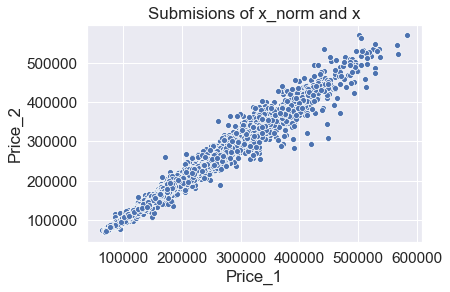

In [594]:
sns.scatterplot(x = 'Price_1', y = 'Price_2', data = preds_final_full)
plt.title('Submisions of x_norm and x')

In [597]:
preds_final['Price'] = preds_final_full['Price']
preds_final.to_csv('predictions29_04 03.csv', index=False)

preds_final.head()

,Id,Price
0,725,162769.921327
1,15856,215636.872322
2,5480,247221.658929
3,15664,337349.183679
4,14275,148225.992027


In [596]:
preds_final.shape

(5000, 2)